#### Выравнивание лиц


После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

Вот так это может выглядеть:

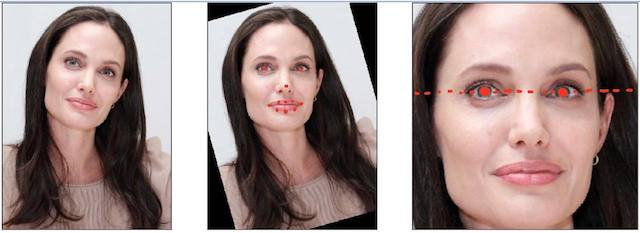

Dataset:  
https://ibug.doc.ic.ac.uk/resources/300-W/  
http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz

In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=cc4fe493486875890edc76bbf61e1d2648397a44cdf9d52c0d9ddf834239a665
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET
import skimage.io
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Data

In [2]:
PATH_TO_DATA = './data/ibug_300W_large_face_landmark_dataset'

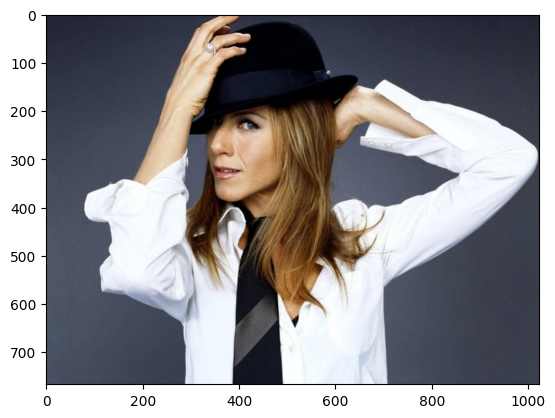

In [3]:
img_name = '/ibug/image_003_1.jpg'
img = skimage.io.imread(f"{PATH_TO_DATA}/{img_name}")
plt.imshow(img);

In [4]:
landmarks = pd.read_csv(f"{PATH_TO_DATA}/{img_name[:-4]}.pts", sep=' ').reset_index()
landmarks = landmarks.iloc[2:-1,:-1]
landmarks['version:'] = landmarks['version:'].astype(float)
landmarks['index'] = landmarks['index'].astype(float)

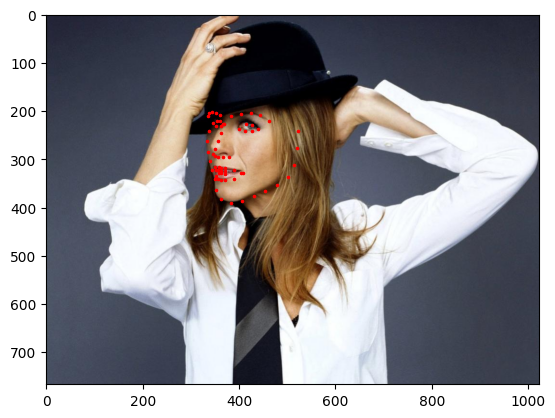

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

plt.figure()
show_landmarks(img, landmarks.values)
plt.show()

In [15]:
tree = ET.parse(f"{PATH_TO_DATA}/labels_ibug_300W_train.xml")
root = tree.getroot()
all_images = []
for filename in root[2]:
    # print(filename.attrib['file'])
    all_images.append(filename.attrib['file'])
    
val_split = set(random.sample(all_images, int(len(all_images) * 0.1)))
len(val_split)

666

In [16]:
class Transforms():
    def __init__(self, mode):
        self.mode = mode

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks


    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        if self.mode == 'train':
            image, landmarks = self.color_jitter(image, landmarks)
            image, landmarks = self.rotate(image, landmarks, angle=10)
            

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        # image = TF.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        return image, landmarks

In [17]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None, mode=None, val_split=[]):

        tree = ET.parse(f"{PATH_TO_DATA}/labels_ibug_300W_train.xml")
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = PATH_TO_DATA
        self.mode = mode

        for filename in root[2]:
            if self.mode == 'val':
                if filename.attrib['file'] in val_split:
                    self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
        
                    self.crops.append(filename[0].attrib)

                    landmark = []
                    for num in range(68):
                        x_coordinate = int(filename[0][num].attrib['x'])
                        y_coordinate = int(filename[0][num].attrib['y'])
                        landmark.append([x_coordinate, y_coordinate])
                    self.landmarks.append(landmark)
            
            else:
                if filename.attrib['file'] not in val_split:
                    self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
                    
                    self.crops.append(filename[0].attrib)

                    landmark = []
                    for num in range(68):
                        x_coordinate = int(filename[0][num].attrib['x'])
                        y_coordinate = int(filename[0][num].attrib['y'])
                        landmark.append([x_coordinate, y_coordinate])
                    self.landmarks.append(landmark)


        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        # print(self.image_filenames[index])
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms(mode='val'), val_split=val_split)

some of images RGB but some of them gray, so we work wih all gray images

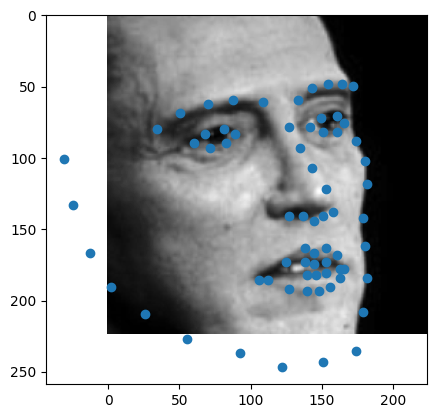

In [18]:
for img, landmarks in dataset:
    landmarks = (landmarks + 0.5) * 224
    plt.imshow(img.numpy().transpose(1,2,0).squeeze(), cmap='gray');
    plt.scatter(landmarks[:,0], landmarks[:,1]);
    break

In [19]:
train_dataset = FaceLandmarksDataset(Transforms(mode='train'), val_split=val_split, mode='train')
valid_dataset = FaceLandmarksDataset(Transforms(mode='val'), val_split=val_split, mode='val')

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=False, drop_last=True)

In [20]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


In [21]:
len(train_dataset), len(valid_dataset)

(6000, 666)

# model

In [22]:
# Set the seed for PyTorch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [23]:
model = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s] 


In [24]:
# Freeze all layers except the last two residual blocks and the fully connected layer
for param in model.parameters():
    param.requires_grad = True
    
# for param in model.layer2.parameters():
#     param.requires_grad = True

# for param in model.layer3.parameters():
#     param.requires_grad = True

# for param in model.layer4.parameters():
#     param.requires_grad = True

In [25]:
class ModelLandmark(nn.Module):
    def __init__(self, model, n_classes):
        super(ModelLandmark, self).__init__()
        self.model = model
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, n_classes)
        

    def forward(self, x):
        x=self.model(x)
        return x

In [26]:
model = ModelLandmark(model, 68 * 2)
criterion = nn.MSELoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-8, betas=(0.95, 0.999))

In [27]:
n_epochs = 10
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

train_losses = []
val_losses = []
loss_min = np.inf

for epoch in tqdm_notebook(range(n_epochs)):
    # Training phase
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0
    
    for step in range(1,len(train_loader)+1):
        inputs, landmarks = next(iter(train_loader))
        inputs = inputs.to(device)
        landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, landmarks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_samples += landmarks.size(0)

    average_loss = total_loss / len(train_loader)
    
    train_losses.append(average_loss)

    print(f"Epoch [{epoch + 1}/{n_epochs}], Train Loss: {average_loss:.4f}")
    
    # Validation phase
    model.eval()
    validation_loss = 0.0
    val_total_samples = 0

    with torch.no_grad():
        for step in range(1,len(valid_loader)+1):
            inputs, landmarks = next(iter(valid_loader))
            inputs = inputs.to(device)
            landmarks = landmarks.view(landmarks.size(0),-1).to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, landmarks)
            
            validation_loss += val_loss.item()
            val_total_samples += landmarks.size(0)

    avg_val_loss = validation_loss / len(valid_loader)
    
    val_losses.append(avg_val_loss)
    
    if avg_val_loss < loss_min:
        loss_min = avg_val_loss
        torch.save(model.state_dict(), './face_landmarks.pth')
    print(f"Epoch [{epoch + 1}/{n_epochs}], Val Loss: {avg_val_loss:.4f}")

/tmp/ipykernel_26/1202186189.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.0460
Epoch [1/10], Val Loss: 0.0048
Epoch [2/10], Train Loss: 0.0054
Epoch [2/10], Val Loss: 0.0045
Epoch [3/10], Train Loss: 0.0049
Epoch [3/10], Val Loss: 0.0041
Epoch [4/10], Train Loss: 0.0041
Epoch [4/10], Val Loss: 0.0033
Epoch [5/10], Train Loss: 0.0031
Epoch [5/10], Val Loss: 0.0025
Epoch [6/10], Train Loss: 0.0022
Epoch [6/10], Val Loss: 0.0017
Epoch [7/10], Train Loss: 0.0017
Epoch [7/10], Val Loss: 0.0015
Epoch [8/10], Train Loss: 0.0015
Epoch [8/10], Val Loss: 0.0011
Epoch [9/10], Train Loss: 0.0013
Epoch [9/10], Val Loss: 0.0009
Epoch [10/10], Train Loss: 0.0011
Epoch [10/10], Val Loss: 0.0008


# predict

In [28]:
model.eval()

with torch.no_grad():
    for step in range(1,len(valid_loader)+1):
        inputs, landmarks = next(iter(valid_loader))
        inputs = inputs.to(device)
        landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        outputs = model(inputs)
        outputs = (outputs.detach() + 0.5) * 224
        outputs = outputs.view(-1, 68, 2)
        break

In [29]:
landmarks = landmarks.view(-1, 68, 2)

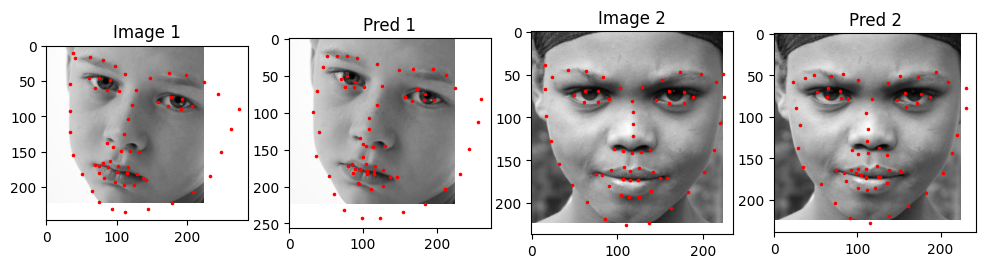

In [35]:
plt.figure(figsize=(12, 4))  # Adjust the figsize as needed

# Plot the first image
plt.subplot(1, 4, 1)
show_landmarks((inputs[0]).detach().cpu().numpy().transpose((1, 2, 0)), (landmarks[0].detach().cpu() + 0.5) * 224)
plt.title('Image 1')

# Plot the second image
plt.subplot(1, 4, 2)
show_landmarks((inputs[0]).detach().cpu().numpy().transpose((1, 2, 0)), outputs[0].detach().cpu())
plt.title('Pred 1')

# Plot the third image
plt.subplot(1, 4, 3)
show_landmarks((inputs[1]).detach().cpu().numpy().transpose((1, 2, 0)), (landmarks[1].detach().cpu() + 0.5) * 224)
plt.title('Image 2')

# Plot the fourth image
plt.subplot(1, 4, 4)
show_landmarks((inputs[1]).detach().cpu().numpy().transpose((1, 2, 0)), outputs[1].detach().cpu())
plt.title('Pred 2')

plt.show()

In [36]:
torch.save(model, './models/model_alignment.bin')
torch.save(model.state_dict(), './models/model_weights_alignment.bin')

# alignment

image that model has never seen before

In [2]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

In [3]:
class ModelLandmark(nn.Module):
    def __init__(self, model, n_classes):
        super(ModelLandmark, self).__init__()
        self.model = model
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, n_classes)
        

    def forward(self, x):
        x=self.model(x)
        return x

In [4]:
model = torch.load('./models/model_alignment.bin', map_location=torch.device('cpu'))

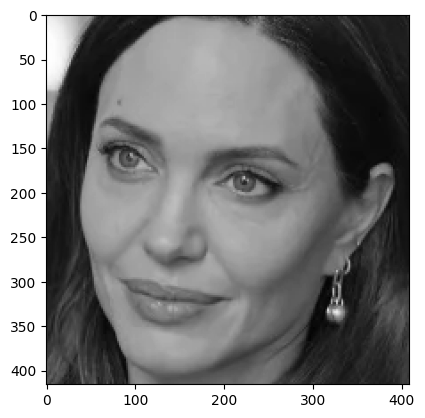

In [5]:
img_name = './data/test_img_crop.jpg'
img = cv2.imread(img_name, 0)
plt.imshow(img, cmap='gray');

In [6]:
def get_landmarks(img):
    img = TF.to_tensor(img)
    img = TF.resize(img, (224,224))
    img = TF.normalize(img, [0.5], [0.5])
    img = img[None,:,:,:]
    
    model.eval()
    with torch.no_grad():
        inputs = img
        outputs = model(inputs)
        outputs = (outputs + 0.5) * 224
        outputs = outputs.view(-1, 68, 2)
    return inputs[0].numpy(), outputs[0].numpy()

In [7]:
img, landmarks = get_landmarks(img)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


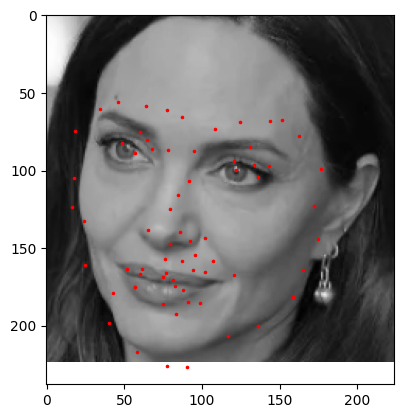

In [8]:
show_landmarks(img.transpose(1, 2, 0), landmarks)

not best, but points near with eyes, that's that we need

In [9]:
def find_angle(image, eyePoints):
    leftEyeX,leftEyeY = eyePoints[0]
    rightEyeX, rightEyeY = eyePoints[1]
    angle = math.atan( (leftEyeY - rightEyeY) / (leftEyeX - rightEyeX) ) * (180/math.pi)
    return angle

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [10]:
def get_align_img(img_name, landmarks):
    img = skimage.io.imread(img_name)
    eyePoints = (landmarks[39], landmarks[42])
    angle = find_angle(img, eyePoints)
    align_img = rotate_image(img, angle)
    return align_img

In [12]:
final_align_img = get_align_img(img_name, landmarks)

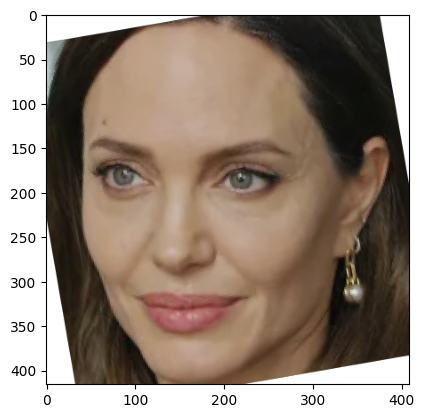

In [13]:
plt.imshow(final_align_img);

seems not bad, we have aligned face by eyes line